## Houseing Price by Garage - Regression
### 차고에 따른 주택 가격 분석 및 예측 - 회귀분석

해당 파트에서 차고의 특성에 따른 주택 가격을 분석하고 예측하고자 한다.

차고의 특성 7개 중 "GarageCars(수용 가능 차량 수)", "GarageArea(차고의 크기), "GarageYrBlt(차고 건설 연도)" 세 개의 특성이 전체 데이터 79개의 특성 중 상관관계 상위 3, 4, 11위에 위치하였다.

이에 따라 위 세 개의 특성뿐만 아니라 차고와 관련된 특성 7개를 활용하여 주택 가격을 분석하고 예측해 본다.

### 0. 목차

1. 라이브러리 호출
2. 데이터 불러들이기
3. 데이터 가공
4. 데이터 전처리
5. 데이터 상관관계 분석
6. 상관관계 검증에 따른 데이터 가공
7. 모델 훈련
8. 모델 선정
9. 결론
10. 마무리

### 1. 라이브러리 호출

In [1]:
### 라이브러리 호출
import pandas as pd
import numpy as np

## 시각화
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

## 상관관계
from scipy.stats import spearmanr, pearsonr

## 데이터 가공
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

## 훈련모델
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

## 평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 오류무시
from sklearn import set_config
set_config(display="text")

### 2. 데이터 불러들이기

In [2]:
### 데이터 불러들이기
# 전처리 된 전체 데이터
file_path = "./data/data_preprocessing.csv"
df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int64
 1   MSZoning       1460 non-null   int64
 2   LotFrontage    1460 non-null   int64
 3   LotArea        1460 non-null   int64
 4   Street         1460 non-null   int64
 5   Alley          1460 non-null   int64
 6   LotShape       1460 non-null   int64
 7   LandContour    1460 non-null   int64
 8   Utilities      1460 non-null   int64
 9   LotConfig      1460 non-null   int64
 10  LandSlope      1460 non-null   int64
 11  Neighborhood   1460 non-null   int64
 12  Condition1     1460 non-null   int64
 13  Condition2     1460 non-null   int64
 14  BldgType       1460 non-null   int64
 15  HouseStyle     1460 non-null   int64
 16  OverallQual    1460 non-null   int64
 17  OverallCond    1460 non-null   int64
 18  YearBuilt      1460 non-null   int64
 19  YearRe

### 3. 데이터 가공

In [3]:
### 차고와 관련된 특성들로 데이터프레임 설정

df_garage = df[["SalePrice", "GarageType", "GarageYrBlt", "GarageFinish",
                "GarageCars", "GarageArea", "GarageQual", "GarageCond"]]
df_garage

SalePrice  GarageType  GarageYrBlt  GarageFinish  GarageCars  \
0        208500           2         2003             2           2   
1        181500           2         1976             2           2   
2        223500           2         2001             2           2   
3        140000           6         1998             3           3   
4        250000           2         2000             2           3   
...         ...         ...          ...           ...         ...   
1455     175000           2         1999             2           2   
1456     210000           2         1978             3           2   
1457     266500           2         1941             2           1   
1458     142125           2         1950             3           1   
1459     147500           2         1965             1           1   

      GarageArea  GarageQual  GarageCond  
0            548           3           3  
1            460           3           3  
2            608           3           3  
3            642           3           3  
4            836           3           3  
...          ...         ...         ...  
1455         460           3           3  
1456         500           3           3  
1457         252           3           3  
1458         240           3           3  
1459         276           3           3  

[1460 rows x 8 columns]

### 4. 데이터 전처리

데이터 전처리의 경우, 이 전 파트에서 전체파일 생성 시 처리했으므로 확인만하고 넘어가도록 한다.

In [4]:
### 데이터 전처리(결측, 이상, 중복)
# 결측치 : 이전 전체 데이터에서 처리
# 이상치 : box_plot으로 확인

plt.title("차고 특성의 이상치 판단")
plt.boxplot(df_garage.iloc[:, 1:])

plt.xlabel("차고 특성")

plt.show()

In [6]:
# "GarageCars" 수용 차량 수의 값은 0, 1, 2, 3, 4인데 한 가구에 네 대의 차가 있을 확률은 있기 때문에
# 이상치 처리를 하지 않고 그대로 사용하기로 한다.
# "GarageQual", "GarageCond" 의 경우 등급을 나타내는 특성으로 이상치처리를 하지 않는다.


In [5]:
### 이상치 처리 후 변수 설정
# 종속변수 : SalePrice
# 독립변수 : GarageType, GarageYrBlt, GarageFinish, GrageCars, GarageArea, GarageQual, GarageCond

X = df_garage.iloc[:, 1:]
y = df_garage["SalePrice"]

X.shape, y.shape

((1460, 7), (1460,))

### 5. 데이터 상관관계 분석
히트맵, corr(), 피어슨, 스피어만을 활용하여 객관적 상관관계 분석

In [6]:
### 상관관계 확인
corr_matrix = df_garage.corr()
corr_matrix

SalePrice  GarageType  GarageYrBlt  GarageFinish  GarageCars  \
SalePrice      1.000000   -0.223819     0.261366     -0.292483    0.640409   
GarageType    -0.223819    1.000000     0.379130      0.583956    0.030107   
GarageYrBlt    0.261366    0.379130     1.000000      0.510562    0.598005   
GarageFinish  -0.292483    0.583956     0.510562      1.000000    0.008036   
GarageCars     0.640409    0.030107     0.598005      0.008036    1.000000   
GarageArea     0.623431    0.034115     0.560783      0.032282    0.882475   
GarageQual     0.273839    0.327411     0.946629      0.462702    0.576622   
GarageCond     0.263191    0.319400     0.949411      0.466932    0.568408   

              GarageArea  GarageQual  GarageCond  
SalePrice       0.623431    0.273839    0.263191  
GarageType      0.034115    0.327411    0.319400  
GarageYrBlt     0.560783    0.946629    0.949411  
GarageFinish    0.032282    0.462702    0.466932  
GarageCars      0.882475    0.576622    0.568408  
GarageArea      1.000000    0.558938    0.547259  
GarageQual      0.558938    1.000000    0.959172  
GarageCond      0.547259    0.959172    1.000000

In [7]:
sns.heatmap(corr_matrix, annot=True, cmap='gray')

<Axes: >

In [8]:
# 스피어만, 피어슨 상관관계 확인을 위한 컬럼 리스트
x_columns_nm = X.columns
x_columns_nm

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [9]:
### 스피어만
for col in x_columns_nm :
    s, p = spearmanr(X[col], y)
    p_msg = "유의미 하지 않음"
    
    if p < 0.05 : 
        p_msg = "유의미 함"
        
    msg = f"""독립변수({col})와 종속변수(집 값)의 상관관계 계수는 {s:.3f}이고, 
pvalue의 값은 {p}임. 따라서 p-value < 0.05에 대하여 {p_msg}
    """
    print(msg)

독립변수(GarageType)와 종속변수(집 값)의 상관관계 계수는 -0.246이고, 
pvalue의 값은 1.2573682844795593e-21임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageYrBlt)와 종속변수(집 값)의 상관관계 계수는 0.634이고, 
pvalue의 값은 4.919472516479396e-165임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageFinish)와 종속변수(집 값)의 상관관계 계수는 -0.381이고, 
pvalue의 값은 8.709053875995303e-52임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageCars)와 종속변수(집 값)의 상관관계 계수는 0.691이고, 
pvalue의 값은 1.6545168265608803e-207임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageArea)와 종속변수(집 값)의 상관관계 계수는 0.649이고, 
pvalue의 값은 1.320918093357304e-175임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageQual)와 종속변수(집 값)의 상관관계 계수는 0.351이고, 
pvalue의 값은 1.3364167636912787e-43임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageCond)와 종속변수(집 값)의 상관관계 계수는 0.339이고, 
pvalue의 값은 1.3608072354450557e-40임. 따라서 p-value < 0.05에 대하여 유의미 함
    


In [10]:
## 피어슨
for col in x_columns_nm :
    s, p = pearsonr(X[col], y)
    p_msg = "유의미 하지 않음"
    
    if p < 0.05 : 
        p_msg = "유의미 함"
        
    msg = f"""독립변수({col})와 종속변수(집 값)의 상관관계 계수는 {s:.3f}이고, 
pvalue의 값은 {p}임. 따라서 p-value < 0.05에 대하여 {p_msg}
    """
    print(msg)

독립변수(GarageType)와 종속변수(집 값)의 상관관계 계수는 -0.224이고, 
pvalue의 값은 4.938072988501536e-18임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageYrBlt)와 종속변수(집 값)의 상관관계 계수는 0.261이고, 
pvalue의 값은 3.1392503099237995e-24임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageFinish)와 종속변수(집 값)의 상관관계 계수는 -0.292이고, 
pvalue의 값은 3.448137521353939e-30임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageCars)와 종속변수(집 값)의 상관관계 계수는 0.640이고, 
pvalue의 값은 2.498644167178585e-169임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageArea)와 종속변수(집 값)의 상관관계 계수는 0.623이고, 
pvalue의 값은 5.265038167971848e-158임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageQual)와 종속변수(집 값)의 상관관계 계수는 0.274이고, 
pvalue의 값은 1.5862882245787516e-26임. 따라서 p-value < 0.05에 대하여 유의미 함
    
독립변수(GarageCond)와 종속변수(집 값)의 상관관계 계수는 0.263이고, 
pvalue의 값은 1.4740139418972217e-24임. 따라서 p-value < 0.05에 대하여 유의미 함
    


In [13]:
"""(해석)
종속변수인 주택 가격에 대해 독립변수인 차고 특성들 모두 유의미한 상관계수가 있음을 알 수 있다.
"""

'(해석)\n종속변수인 주택 가격에 대해 독립변수인 차고 특성들 모두 유의미한 상관계수가 있음을 알 수 있다.\n'

### 6. 각 특성에 따른 시각화

In [11]:
plt.title("차고 면적에 따른 주택 가격 시각화")
plt.scatter(X["GarageArea"], y, c="blue")
# plt.scatter(X["GarageCars"], y, c="yellow")

plt.xlabel("차고 면적")
plt.ylabel("주택 가격")

Text(0, 0.5, '주택 가격')

Text(0, 0.5, '주택 가격')

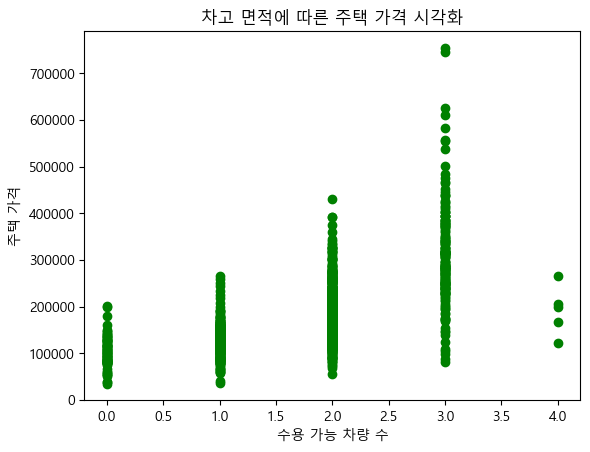

In [16]:
plt.title("차고 면적에 따른 주택 가격 시각화")
plt.scatter(X["GarageCars"], y, c="green")

plt.xlabel("수용 가능 차량 수")
plt.ylabel("주택 가격")

### 7. 상관관계 검증에 따른 데이터 가공
훈련 : 검증 : 테스트 = 6 : 2 : 2

In [17]:
### 변수 설정
# 종속변수 : SalePrice
# 독립변수 : GarageType, GarageYrBlt, GarageFinish, GrageCars, GarageArea, GarageQual, GarageCond

X = df_garage.iloc[:, 1:]
y = df_garage["SalePrice"]

X.shape, y.shape

((1460, 7), (1460,))

In [18]:
train_input, val_test, train_target, val_tet_target = train_test_split(
    X,
    y,
    test_size=0.4,
    random_state=42
)

val_input, test_input, val_target, test_target = train_test_split(
    val_test,
    val_tet_target,
    test_size=0.5,
    random_state=42
)

train_input = train_input.to_numpy()
val_input = val_input.to_numpy()
test_input = test_input.to_numpy()

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)

(876, 7) (876,)
(292, 7) (292,)
(292, 7) (292,)


### 8. 모델 훈련

In [19]:

### 튜닝
## 01. 하이퍼파라메터 정의
# 1. LinearRegression, Ridge, Lasso에서 사용
linear_params = {"fit_intercept" : [True, False],
                 "positive" : [True, False]}

# 2. GradentBoostingRegressor에서 사용
gb_params = {"n_estimators" : [50, 100],
             "max_depth" : [None, 3, 10],
             "learning_rate" : [0.01, 0.1, 0.2]}

# 3. HistGradientBoostingRegressor에서 사용
hgb_params = {"max_iter" : [50, 100],
             "max_depth" : [None, 3, 10],
             "learning_rate" : [0.01, 0.1, 0.2]}

# 4. RandomForestRegressor, XGBRegressor, ExtraTreesRegressor에서 사용
rf_et_xgb_params = {"n_estimators" : [50, 100],
             "max_depth" : [None, 3, 10]}

kn_params = {}

## 02. 속성 정의
scoring = ["neg_mean_squared_error", "r2"]
refit = "r2"
cv = 5
n_jobs = -1

In [19]:
def getScore(model, train_input, train_target, val_input, val_target, test_input, test_target):
    train_score = model.score(train_input, train_target)
    val_score = model.score(val_input, val_target)
    test_score = model.score(test_input, test_target)
    
    train_val = train_score - val_score
    
    return train_score, val_score, test_score, train_val

def getError(model, train_input, train_target, val_input, val_target, test_input, test_target):
    ## 예측
    train_pred = model.predict(train_input)
    val_pred = model.predict(val_input)
    test_pred = model.predict(test_input)
    
    ## 평가
    train_mae = mean_absolute_error(train_target, train_pred)
    val_mae = mean_absolute_error(val_target, val_pred)
    test_mae = mean_absolute_error(test_target, test_pred)
    
    train_mse = mean_squared_error(train_target, train_pred)
    val_mse = mean_squared_error(val_target, val_pred)
    test_mse = mean_squared_error(test_target, test_pred)
    
    train_r2 = r2_score(train_target, train_pred)
    val_r2 = r2_score(val_target, val_pred)
    test_r2 = r2_score(test_target, test_pred)
    
    return train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2

## 04. 튜닝 함수
def setGSCV(model, model_nm, train_input, train_target):
    gridparams = {}
    if model_nm in ["LinearRegression", "Ridge", "Lasso"]:
        gridparams = linear_params
    elif model_nm in ["GradentBoostingRegressor"]:
        gridparams = gb_params
    elif model_nm in ["HistGradientBoostingRegressor"]:
        gridparams = hgb_params
    elif model_nm in ["KNeighborsRegressor"]:
        gridparams = kn_params
    else: 
        gridparams = rf_et_xgb_params
    
    grid_search_model = GridSearchCV(
        # 튜닝에 사용할 모델 설정
        estimator = model,
        # 위에서 정의한 하이퍼파라메터 설정
        param_grid = gridparams,
        # 모델 평가방법 설정
        scoring = scoring,
        # 모델 선정 기준 설정
        refit = refit,
        # 교차검증에 사용할 Fold 갯수 설정
        cv = cv,
        # CPU Core(코어) 갯수 설정
        n_jobs = n_jobs
    )
    
    grid_search_model.fit(train_input, train_target)
    
    best_params = grid_search_model.best_params_
    best_score = grid_search_model.best_score_
    best_model = grid_search_model.best_estimator_
    
    return best_model, best_params

In [20]:
### 모델 생성
## 결정계수 확인하기
liner_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
rf_reg    = RandomForestRegressor()
ext_reg   = ExtraTreesRegressor()
gb_reg    = GradientBoostingRegressor()
hgb_reg   = HistGradientBoostingRegressor()
xgb_reg   = XGBRegressor()

models = [liner_reg, ridge_reg, lasso_reg, rf_reg, ext_reg, gb_reg, hgb_reg, xgb_reg]

In [21]:
df_garage = pd.DataFrame()

for degree in range(1, 5):
    print("특성공학 :", degree)
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly.fit(train_input)

    train_poly = poly.transform(train_input)
    val_poly = poly.transform(val_input)
    test_poly = poly.transform(test_input)

    for model in models:
        model_nm = model.__class__.__name__
        # print(model_nm)
        
        model.fit(train_poly, train_target)
        train_score, val_score, test_score, train_val = getScore(model, train_poly, train_target, val_poly, val_target, test_poly, test_target)
        
        train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2 = getError(model, train_poly, train_target, val_poly, val_target, test_poly, test_target)
        
        data = {
            "모델명": [model_nm],
            "특성공학": [degree],
            "스케일링": [False],
            "하이퍼파라메터_튜닝": [False],
            "훈련MSE": [train_mae], "검증MSE": [val_mae], "테스트MSE": [test_mse],
            "훈련R2": [train_r2], "검증R2": [val_r2], "테스트R2": [test_r2],
            "과적합여부": [train_r2 - val_r2]
        }
        df_temp = pd.DataFrame(data)
        
        df_garage = pd.concat([df_garage, df_temp], ignore_index=True)
        
        best_model, best_params = setGSCV(model, model_nm, train_poly, train_target)
        
        train_score, val_score, test_score, train_val = getScore(best_model, train_poly, train_target, val_poly, val_target, test_poly, test_target)
        
        train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2 = getError(best_model, train_poly, train_target, val_poly, val_target, test_poly, test_target)
                
        data = {
            "모델명": [model_nm],
            "특성공학": [degree],
            "스케일링": [False],
            "하이퍼파라메터_튜닝": [True],
            "훈련MSE": [train_mae], "검증MSE": [val_mae], "테스트MSE": [test_mse],
            "훈련R2": [train_r2], "검증R2": [val_r2], "테스트R2": [test_r2],
            "과적합여부": [train_r2 - val_r2]
        }
        df_temp = pd.DataFrame(data)
        
        df_garage = pd.concat([df_garage, df_temp], ignore_index=True)
        
        ### 스케일링 후 모델명 훈련
        ss = StandardScaler()
        mm = MinMaxScaler()
        rb = RobustScaler()
        scalers = [ss, mm, rb]
        for scaler in scalers:
            scaler_nm = scaler.__class__.__name__
            
            scaler.fit(train_poly)
            
            train_scaled = ss.transform(train_poly)
            val_scaled = ss.transform(val_poly)
            test_scaled = ss.transform(test_poly)
            
            model.fit(train_scaled, train_target)
            
            train_score, val_score, test_score, train_val = getScore(model, train_scaled, train_target, val_scaled, val_target, test_scaled, test_target)
            
            train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2 = getError(model, train_scaled, train_target, val_scaled, val_target, test_scaled, test_target)
            
            data = {
                "모델명": [model_nm],
                "특성공학": [degree],
                "스케일링": [scaler_nm],
                "하이퍼파라메터_튜닝": [False],
                "훈련MSE": [train_mae], "검증MSE": [val_mae], "테스트MSE": [test_mse],
                "훈련R2": [train_r2], "검증R2": [val_r2], "테스트R2": [test_r2],
                "과적합여부": [train_r2 - val_r2]
            }
            df_temp = pd.DataFrame(data)
            
            df_garage = pd.concat([df_garage, df_temp], ignore_index=True)
            
            ## 하이퍼파라메터_튜닝+스케일링
            best_model, best_params = setGSCV(model, model_nm, train_poly, train_target)
            
            train_score, val_score, test_score, train_val = getScore(model, train_scaled, train_target, val_scaled, val_target, test_scaled, test_target)
            
            train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2 = getError(model, train_scaled, train_target, val_scaled, val_target, test_scaled, test_target)
            
            data = {
                "모델명": [model_nm],
                "특성공학": [degree],
                "스케일링": [scaler_nm],
                "하이퍼파라메터_튜닝": [True],
                "훈련MSE": [train_mae], "검증MSE": [val_mae], "테스트MSE": [test_mse],
                "훈련R2": [train_r2], "검증R2": [val_r2], "테스트R2": [test_r2],
                "과적합여부": [train_r2 - val_r2]
            }
            df_temp = pd.DataFrame(data)
            
            df_garage = pd.concat([df_garage, df_temp], ignore_index=True)
            
df_garage

특성공학 : 1
특성공학 : 2


c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=5.90005e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.13556e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.13556e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.13556e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\U

특성공학 : 3


c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.05497e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.629e+11, tolerance: 4.973e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.294e+11, tolerance: 3.333e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\Mi

특성공학 : 4


c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e+11, tolerance: 4.973e+08
  model = cd_fast.enet_coordinate_descent(
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.106e+11, tolerance: 3.333e+09
  model = cd_fast.enet_coordinate_descent(
c:\Users\Minyo\anaconda3\envs\miniproject1\lib\site-pa

KeyboardInterrupt: 

### 9. 모델 선정

##### 모델 선정 조건

In [ ]:
df_garage_fillter = df_garage.copy()

## 객관적 선정 조건
# 과적합여부 
c = (0.01 < df_garage_fillter["과적합여부"]) & (df_garage_fillter["과적합여부"] < 0.09)
df_garage_fillter = df_garage_fillter[c == True]

## 주관적 선정 조건
# 훈련결정계수가 높은 순
df_garage_fillter = df_garage_fillter.sort_values("훈련R2",ascending=False)
df_garage_fillter = df_garage_fillter.reset_index()

df_garage_fillter

NameError: name 'df_garage' is not defined

In [ ]:
"""(모델 선정 해석)
- 차고 특성에 따른 주택 가격을 예측하기 위한 결과는 다음과 같다

- 선정 모델 : GradientBoostingRegressor
- 4차원, 스케일링은 하지 않고 하이퍼파라메터 튜닝을 진행했을 때 훈련 결정계수(R2) 0.768108로 나타났다.

<모델 선정 기준>
1. 객관적 선정 기준
  - 일반화 여부
    0.01 < 훈련 결정계수 - 테스트 결정계수 < 0.09 
    -> 과소적합(음수인 경우), 과대적합(0.09 이상인 경우) 제외
  - train_r2, val_42가 0 이상인 경우
    -> Lasso 모델의 경우 음수가 나올 수 있기에 음수는 제외

2. 주관적 선정 기준
  - 여러 모델 중에서 객관적 선정 기준을 통과한 모델 훈련 경우의 수 중에서 최종 모델을 선정
  1) 오차값(MAE)의 차이가 많이 날 경우에는 오차값을 기준으로 선정
    : 오차값이 작을 수록 좋다
  2) 훈련 결정계수(R2) 값이 높은 것
    : 여러 경우의 수 중에서 오차값의 차이가 많이 나는 경우가 없기 때문에 훈련 결정계수가 높은 기준으로 선정

<최종 모델 선정>
 - 위 1번의 객관적 선정 기준에 따라 256개의 경우의 수 중에서 36개의 유의미한 경우의 수를 추출
 - 사용 가능한 모델 : GradientBoostingRegressor, HistGradientBoostingRegressor, Ridge, Lasso
 - 최종적으로 GradientBoostingRegressor의 조건이 특성공학 4차원 처리, 스케일링은 하지 않았으며 하이퍼파라메터 튜닝을 진행했을 때 일반화가 나타나지 않았으며 훈련 결정계수(R2)가 가장 높게 나타났다.
  
"""

'(모델 선정 해석)\n- 차고 특성에 따른 주택 가격을 예측하기 위한 결과는 다음과 같다\n\n- 선정 모델 : GradientBoostingRegressor\n- 4차원, 스케일링은 하지 않고 하이퍼파라메터 튜닝을 진행했을 때 훈련 결정계수(R2) 0.768108로 나타났다.\n\n<모델 선정 기준>\n1. 객관적 선정 기준\n  - 일반화 여부\n    0.01 < 훈련 결정계수 - 테스트 결정계수 < 0.09 \n    -> 과소적합(음수인 경우), 과대적합(0.09 이상인 경우) 제외\n  - train_r2, val_42가 0 이상인 경우\n    -> Lasso 모델의 경우 음수가 나올 수 있기에 음수는 제외\n\n2. 주관적 선정 기준\n  - 여러 모델 중에서 객관적 선정 기준을 통과한 모델 훈련 경우의 수 중에서 최종 모델을 선정\n  1) 오차값(MAE)의 차이가 많이 날 경우에는 오차값을 기준으로 선정\n    : 오차값이 작을 수록 좋다\n  2) 훈련 결정계수(R2) 값이 높은 것\n    : 여러 경우의 수 중에서 오차값의 차이가 많이 나는 경우가 없기 때문에 훈련 결정계수가 높은 기준으로 선정\n\n<최종 모델 선정>\n - 위 1번의 객관적 선정 기준에 따라 256개의 경우의 수 중에서 36개의 유의미한 경우의 수를 추출\n - 사용 가능한 모델 : GradientBoostingRegressor, HistGradientBoostingRegressor, Ridge, Lasso\n - 최종적으로 GradientBoostingRegressor의 조건이 특성공학 4차원 처리, 스케일링은 하지 않았으며 하이퍼파라메터 튜닝을 진행했을 때 일반화가 나타나지 않았으며 훈련 결정계수(R2)가 가장 높게 나타났다.\n  \n'

In [ ]:
### 선정된 모델로 학습
poly = PolynomialFeatures(degree=4, include_bias=False)
poly.fit(train_input)

train_poly = poly.transform(train_input)
val_poly = poly.transform(val_input)

gb = GradientBoostingRegressor()
gb.fit(train_poly, train_target)
model_nm = gb.__class__.__name__

best_model = setGSCV(gb, model_nm, train_poly, train_target)

train_score, val_score, test_score, train_val = getScore(best_model, train_poly, train_target, val_poly, val_target, test_poly, test_target)

train_mae, val_mae, test_mae, train_mse, val_mse, test_mse, train_r2, val_r2, test_r2 = getError(best_model, train_poly, train_target, val_poly, val_target, test_poly, test_target)

print(f"모델명 : {best_model.__class__.__name__}, 훈련 결정계수 : {train_r2}, 검증 결정계수 : {val_r2}, 테스트 결정계수 : {test_r2}")
print(f"과적합여부 : {train_r2 - val_r2}, 훈련MSE : {train_mse}, 검증MSE : {val_mse}, 테스트MSE : {test_mse}")


모델명 : GradientBoostingRegressor, 훈련 결정계수 : 0.7649492071270415, 검증 결정계수 : 0.6846628096427361, 테스트 결정계수 : 0.6348982077751795
과적합여부 : 0.08028639748430544, 훈련MSE : 1334400424.1917973, 검증MSE : 2969603933.8290563, 테스트MSE : 1785562884.1184027


### 10. 결론

In [ ]:
"""(결론 해석)
- 미국 보스턴 지역의 주택 가격을 결정하는 데 있어 차고와 관련된 특성은 중요한 요소를 차지하는 것으로 보인다.
- 차고 관련 특성과 주택 가격의 상관관계
  - GarageCars(차고 수용 차량 수) : 0.64
  - GarageArea(차고 넓이) : 0.62
  - GarageYrBlt(차고 생성 연도) : 0.49
  - 이 외에도 차고와 관련된 총 7개의 특성이 주택 가격과 유의미한 상관관계가 나타났다.
- 위 차고 관련 특성들을 포함한 모델을 통해 주택 가격을 예측한 결과 "0.77"의 결정계수를 달성하였으며,
  차고 관련 틍석이 주택 가격 예측에 있어서 중요한 요소임을 보여준다.
"""

'(결론 해석)\n- 미국 보스턴 지역의 주택 가격을 결정하는 데 있어 차고와 관련된 특성은 중요한 요소를 차지하는 것으로 보인다.\n- 차고 관련 특성과 주택 가격의 상관관계\n  - GarageCars(차고 수용 차량 수) : 0.64\n  - GarageArea(차고 넓이) : 0.62\n  - GarageYrBlt(차고 생성 연도) : 0.49\n  - 이 외에도 차고와 관련된 총 7개의 특성이 주택 가격과 유의미한 상관관계가 나타났다.\n- 위 차고 관련 특성들을 포함한 모델을 통해 주택 가격을 예측한 결과 "0.77"의 결정계수를 달성하였으며,\n  차고 관련 틍석이 주택 가격 예측에 있어서 중요한 요소임을 보여준다.\n'